In [1]:
%%info

In [2]:
# %%configure -f 
# {"driverMemory": "6000M"}

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
10,application_1646663664520_0012,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package('pip==22.0.4')
sc.install_pypi_package('tensorflow')
sc.install_pypi_package('scipy')
sc.install_pypi_package('scikit-learn')
sc.install_pypi_package('pandas==0.23.2')
sc.install_pypi_package('numpy==1.17.4')
sc.install_pypi_package('matplotlib==3.3.0')
sc.install_pypi_package('seaborn==0.11.2')
sc.install_pypi_package('scikit-image==0.19.2')
# sc.install_pypi_package('sparkdl')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
11,application_1646663664520_0013,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4d/16/0a14ca596f30316efd412a60bdfac02a7259bf8673d4d917dc60b9a21812/pip-22.0.4-py3-none-any.whl
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached setuptools-60.9.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Not uninstalling typing-extensions at /usr/local/lib64/python3.7/site-pack

In [3]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import pickle

from skimage.transform import resize
from skimage.io import imread
from PIL import Image
# import tensorflow as tf
# from keras.preprocessing import image

from pyspark.sql.functions import input_file_name, regexp_extract, col
from pyspark.sql import functions as F

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Loading Data

In [24]:
url = 's3://pguevara-bdcc2022/mask_project/medical-masks-part1/images/00000?_?_00000?_*.jpg'
df = (spark.read.format("image").load(url)
      .withColumn('label', F.substring(col('image.origin'), 71, 1).cast('int')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: integer (nullable = true)

### Testing Image Display

In [8]:
df_test = df.limit(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
test = df_test[['image.data']].toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
test_dim = df_test.select('image.height', 'image.width', 'image.nChannels', 'image.mode')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
test_dim.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+---------+----+
|height|width|nChannels|mode|
+------+-----+---------+----+
|  3264| 2448|        3|  16|
|  3088| 2316|        3|  16|
+------+-----+---------+----+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

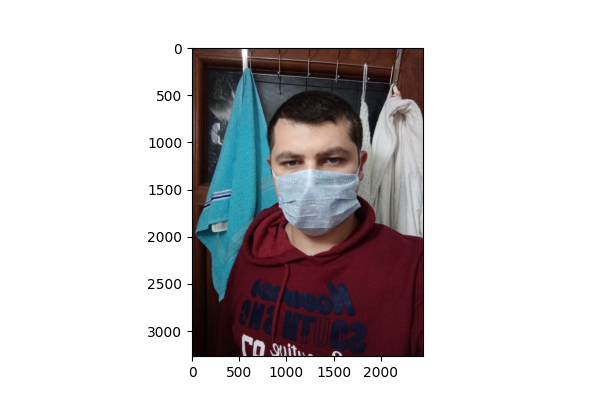

In [12]:
face = np.array(test.data[0]).reshape(3264,2448,3)[:,:,::-1]
face_img = Image.fromarray(face)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_img)
print(face.shape)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

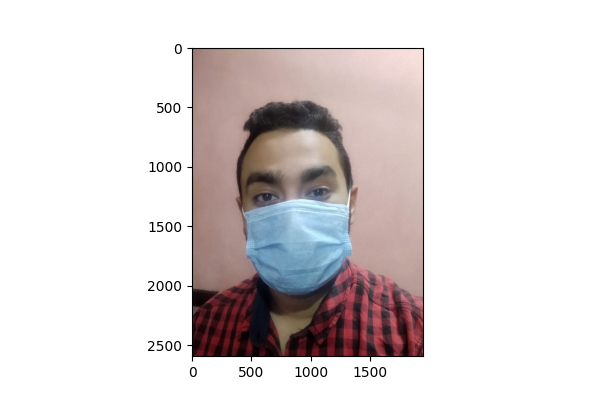

In [13]:
face = np.array(test.data[1]).reshape(2592,1944,3)[:,:,::-1]
face_img = Image.fromarray(face)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_img)
print(face.shape)
%matplot plt

### Creating Features

In [26]:
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT
 
# print(ImageSchema.imageFields)

img2vec = (F.udf(lambda x:
                 DenseVector(resize(ImageSchema.toNDArray(x[0])[:,:,::-1],
                                    (128, 128),
                                    order=1,
                                    preserve_range=True,
                                    anti_aliasing=True).
                             astype('uint8').
                             flatten()),
                 VectorUDT()))

df = (df.withColumn('vecs', img2vec(F.struct('image'))).select('vecs', 'label'))


# CPT10 code:
# binary = F.udf(lambda x: 1 if x<=12 else 0)
# df = (df.withColumn('vecs', img2vec(F.struct('image', 'height', 'left', 'top', 'width'))))
#      .withColumn('label', binary('age').astype('int')).select('vecs', 'label'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- vecs: vector (nullable = true)
 |-- label: integer (nullable = true)

In [18]:
# df_test2 = df.limit(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# df_test2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: integer (nullable = true)
 |-- vecs: vector (nullable = true)

In [28]:
# test2 = df_test2[['vecs']].toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# face = test2[0][-1].shape

# face = test2[0][-1].reshape(128,128,3)
# face_img = Image.fromarray(np.uint8(face))

# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(face_img)

# plt.show()
# %matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
df.groupby('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1|    6|
|    3|    4|
|    4|    5|
|    2|    3|
+-----+-----+

### Model

In [30]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

# df_training, df_test = df.randomSplit([0.7, 0.3], seed=143)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
df_training, df_test = df.randomSplit([0.7, 0.3], seed=143)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# If using Logistic Regression
lsvc = LogisticRegression(featuresCol='vecs',
                          labelCol='label')

# If using Random Forest
rf_class = RandomForestClassifier(featuresCol='vecs',
                                  labelCol='label',
                                  maxBins=1000, seed=143)

pipe = Pipeline(stages=[rf_class])

model_trained = pipe.fit(df_training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:

  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1646663664520_0013/container_1646663664520_0013_01_000011/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/mnt/yarn/usercache/livy/appcache/application_1646663664520_0013/container_1646663664520_0013_01_000011/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/mnt/yarn/usercache/livy/appcache/application_1646663664520_0013/container_1646663664520_0013_01_000011/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/mnt/yarn/usercache/livy/appcache/application_1646663664520_0013/container_1646663664520_0013_01_000011/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/mnt/yarn/usercache/l

In [ ]:
df_predict = model_trained.transform(df_test)

df_predict[['label', 'prediction']].show()